---
title: Naive NerFs
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

> Neural Fields (NerFs) are an emerging class of coordinate-based neural networks. There has been many developments in the last few years for applying NerFs to data like images. In this tutorial, I will introduce NerFs from the geoscience perspective and highlight some potential advantages to using these methods. I will demonstrate some concrete work on sea surface height interpolation and highlight some of the problems (and potential solutions) I faced when applying this class of methods to spatiotemporal data.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import optax
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from dataclasses import dataclass
import hydra
from omegaconf import OmegaConf

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Coordinate-Based Models

$$
\mathbf{x}\in\mathbb{R}^D
$$

**Example I**: Time Series

$$
\begin{aligned}
\text{Input}: && t &\in \mathbb{R}^+ \\
\text{Outpit}: && f  &: \mathbb{R}\rightarrow\mathbb{R}^U
\end{aligned}
$$

**Example II:** Images

$$
x,y \in \mathbb{R}
$$

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
from dataclasses import dataclass


@dataclass
class FoxDM:
    _target_: str = "jejeqx._src.datamodules.image.ImageFox"
    batch_size: int = 10_000
    resize: int = 2
    shuffle: bool = False
    split_method: str = "even"
    image_url: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/images/fox.jpg"
    
config_dm = OmegaConf.structured(FoxDM())

In [3]:
dm = hydra.utils.instantiate(config_dm)
dm.setup()


init = dm.ds_train[:32]
x_init, y_init = init

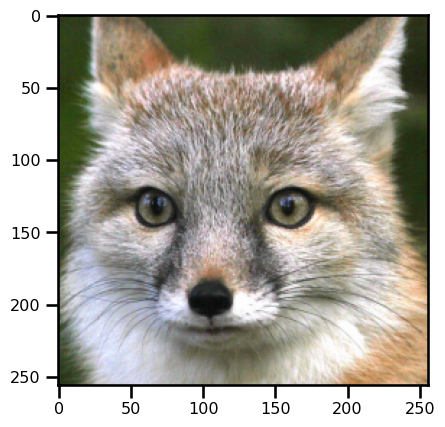

In [4]:
img = dm.load_image()
img.shape

plt.figure()
plt.imshow(img)
plt.show()

## Coordinates


$$
\vec{\mathbf{x}} = 
\begin{bmatrix}
x \\ y
\end{bmatrix}
$$

$$
\mathbf{y} =
\begin{bmatrix}
R \\ B \\ G
\end{bmatrix}
$$

In [5]:
print(f"Image Shape: {img.shape}")
print(f"Number of Coords: {len(dm.ds_train):,}")

Image Shape: (256, 256, 3)
Number of Coords: 32,768


## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [6]:
from typing import Dict
from dataclasses import field


@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"

@dataclass
class IdentityAct:
    _target_: str = "equinox.nn.Identity"
    
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123

@dataclass
class MLPModel:
    _target_: str = "equinox.nn.MLP"
    in_size: int = 2
    out_size: int = 3
    width_size: int = 128
    depth: int = 5
    activation: Activation = Activation()
    final_activation: IdentityAct = IdentityAct()
    key: Key = Key(seed=42)

In [7]:
# initialize model
model_config = OmegaConf.structured(MLPModel())

model = hydra.utils.instantiate(model_config)

eqx.tree_pprint(model)

MLP(
  layers=(
    Linear(
      weight=f32[128,2],
      bias=f32[128],
      in_features=2,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f32[3,128],
      bias=f32[3],
      in_features=128,
      out_features=3,
      use_bias=True
    )
  ),
  activation=ReLU(),
  final_activation=Identity(),
  in_size=2,
  out_size=3,
  width_size=128,
  depth=5
)


**Note**: We have created a function that takes a vector and outputs a vector. In JAX, we don't have to think about batches until later. 

In [8]:
# check output of models
x_vector, y_vector = x_init[0], y_init[0]

# predict
out_vector = model(x_vector)

assert out_vector.shape == y_vector.shape

Now, we can batches by *autovectorizing* using `vmap`.

In [9]:
# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape


## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `2_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [10]:
import optax

num_epochs = 2_000

@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4

@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e0
    warmup_steps: int = 500
    end_value: float = 1e-5

use_scheduler = False

In [11]:
optim_config = OmegaConf.structured(Optimizer())
scheduler_config = OmegaConf.structured(Scheduler())

# initialize optimizer
optimizer = hydra.utils.instantiate(optim_config)

if use_scheduler:
    num_steps_per_epoch = len(dm.ds_train)

    scheduler = hydra.utils.instantiate(
        scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
    )

    # initialize optimizer with scheduler
    optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).


We are interested posterior of the parameters given the data. So we can use Bayes theorem to express this.

$$
p(\boldsymbol{\theta}|\mathcal{D}) \propto p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})
$$


This can be solved by using the maximimum likelihood method. So in this case, we need to define the likelihood term for the *data*. We can assume a Gaussian likelihood because we are working with continuous data. To make things simple, we can also assume a constant noise.

$$
p(y|\mathbf{x};\boldsymbol{\theta})=\mathcal{N}
\left(
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}), \sigma^2
\right)
$$

This is the *maximum likelihood estimation* problem. If we assume our samples are i.i.d., we get the following minimization problem

$$
\boldsymbol{\theta} = \underset{\boldsymbol{\theta}}{\text{argmin}}
\hspace{1mm} \sum_{y,\mathbf{x}\in\mathcal{D}}-\log p(y|\mathbf{x};\boldsymbol{\theta})
$$

Notice the slight of hand: the minimization of the negative log-likelihood is the same as the maxmimization of the log likelihood.

 If we assume a noise level of 1, i.e. $\sigma=1$, then this loss reduces to the *mean squared error* (MSE) loss function:

$$
\mathcal{L}(\boldsymbol{\theta}) = 
\frac{1}{|\mathcal{D}|} \sum_{n\in\mathcal{D}}
\left(y - \boldsymbol{f_\theta}(\mathbf{x})\right)^2
$$

We can take minibatches

$$
\mathcal{B}=\left\{\mathbf{x}_b,y_b \right\}^B_{b=1}
$$

which is a proper subset of the dataset, $\mathcal{B} \mathcal{D}=\mathcal{B}$.

So our new loss function will be:

$$
\mathcal{L}(\boldsymbol{\theta}) = 
\frac{1}{|\mathcal{B}|} \sum_{n\in\mathcal{B}}
\left(y - \boldsymbol{f_\theta}(\mathbf{x})\right)^2
$$

## Trainer Module

In [12]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def test_step(model, batch):
            x, y = batch
            out = jax.vmap(model)(x)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}

        def predict_step(model, batch):
            x, y = batch
            out = jax.vmap(model)(x)
            return out
        
        return train_step, eval_step, test_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [13]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)


In [14]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.37384870648384094, 'psnr': 3.4702701568603516}

In [15]:
trainer.load_model("./checkpoints/checkpoint_model_mlp.ckpt")

In [16]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.008850343525409698, 'psnr': 41.5156135559082}

In [17]:
%%time

# metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 16 µs, sys: 7 µs, total: 23 µs
Wall time: 45.5 µs


In [18]:
# trainer.save_model("./checkpoints/checkpoint_model_mlp.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [19]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.008850343525409698, 'psnr': 41.5156135559082}

In [20]:
all_metrics = pd.DataFrame(
    data=[["mlp", metrics["loss"], metrics["psnr"]]],
    columns=["model", "MSE", "SNR"],
)
all_metrics

,model,MSE,SNR
0,mlp,0.00885,41.515614


In [21]:
out_mlp = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


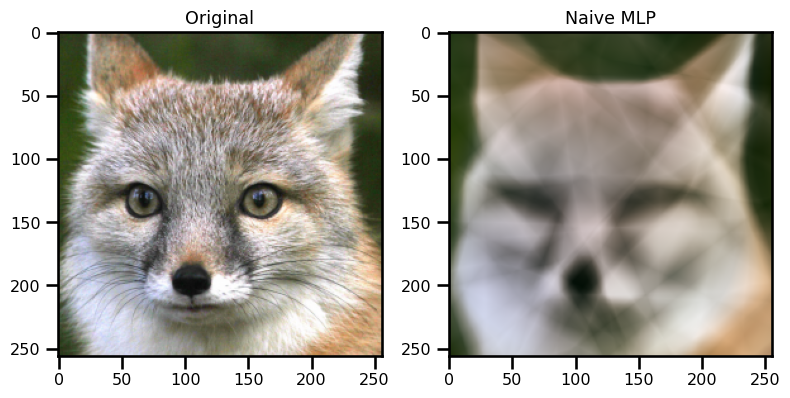

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].imshow(img)
ax[0].set(title="Original")
ax[1].imshow(out_mlp)
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

### Random Fourier Features

$$
\boldsymbol{\phi}(\mathbf{x}) = 
\sqrt{\frac{\sigma^2}{N_{RF}}}
\left[
\cos(\boldsymbol{\Omega}\mathbf{x}),
\sin(\boldsymbol{\Omega}\mathbf{x})
\right]
$$

where $\boldsymbol{\Omega}$ is a random matrix sampled from a Gaussian distribution.

$$
\begin{aligned}
p(\Omega)&\sim\mathcal{N}(0,\boldsymbol{\Lambda}^{-1}_D) \\
\boldsymbol{\Lambda}_D &= \text{diag}
\left(\lambda_1, \lambda_2, \ldots, \lambda_D\right)
\end{aligned}
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [23]:
from typing import Dict
from dataclasses import field

@dataclass
class RFFModel:
    _target_: str = "jejeqx._src.nets.nerfs.ffn.RFFNet"
    in_size: int = 2
    out_size: int = 3
    width_size: int = 256
    depth: int = 5
    ard: bool = True
    method: str = "rbf"
    key: Key = Key(seed=42)

In [24]:
# initialize model
model_config = OmegaConf.structured(RFFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

In [25]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"
num_epochs = 6_000

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [26]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.37075990438461304, 'psnr': 3.5415873527526855}

In [27]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_rff.ckpt")
except:
    RuntimeError()

In [28]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.002839250024408102, 'psnr': 53.401885986328125}

In [29]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 19 µs, sys: 6 µs, total: 25 µs
Wall time: 49.4 µs


In [30]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_rff.ckpt")

In [31]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.002839250024408102, 'psnr': 53.401885986328125}

In [32]:
all_metrics = pd.concat(
    [all_metrics,
    pd.DataFrame(
        data=[["rff", metrics["loss"], metrics["psnr"]]],
        columns=["model", "MSE", "SNR"],
    )]
)

In [33]:
all_metrics

,model,MSE,SNR
0,mlp,0.008850,41.515614
0,rff,0.002839,53.401886


In [34]:
out_rff = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


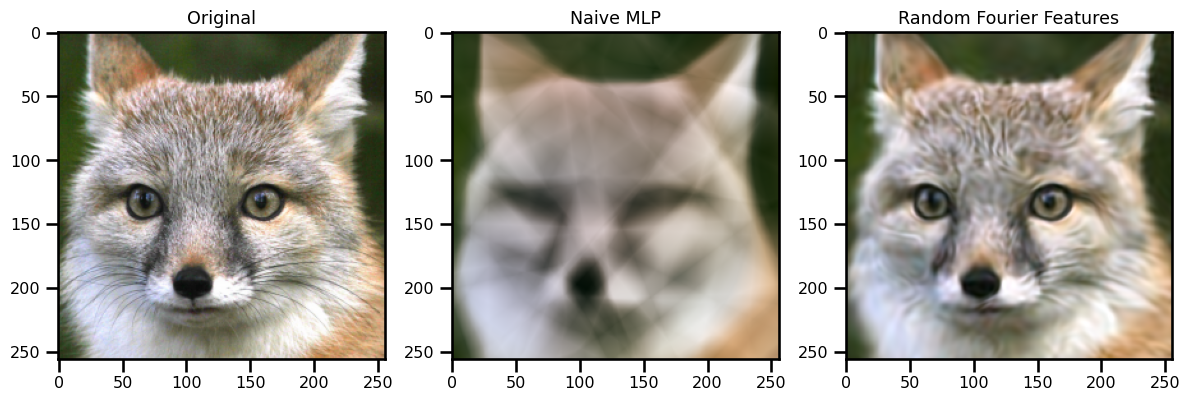

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].imshow(img)
ax[0].set(title="Original")
ax[1].imshow(out_mlp)
ax[1].set(title="Naive MLP")
ax[2].imshow(out_rff)
ax[2].set(title="Random Fourier Features")

plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [36]:
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123

@dataclass
class SirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
    in_size: int = 2
    out_size: int = 256
    width_size: int = 256
    depth: int = 5
    key: Key = Key()
    
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = 256
    out_features: int = 3
    use_bias: bool = True
    key: Key = Key()
    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    network: LinearModel = LinearModel()
    basis_net: SirenBasis = SirenBasis()

In [37]:
from jejeqx._src.nets.nerfs.base import NerF

In [38]:
# initialize model
model_config = OmegaConf.structured(NerFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

# assert out.shape == y_init.shape
# eqx.tree_pprint(model)
out.shape

(32, 3)

In [39]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [40]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.47536465525627136, 'psnr': 0.8998085260391235}

In [41]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_siren.ckpt")
except:
    pass

In [42]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.0019353348761796951, 'psnr': 57.65052795410156}

In [43]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 0 ns, sys: 24 µs, total: 24 µs
Wall time: 48.6 µs


In [44]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_siren.ckpt")

In [45]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.0019353348761796951, 'psnr': 57.65052795410156}

In [46]:
all_metrics = pd.concat(
    [all_metrics,
    pd.DataFrame(
        data=[["siren", metrics["loss"], metrics["psnr"]]],
        columns=["model", "MSE", "SNR"],
    )]
)


In [47]:
out_siren = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


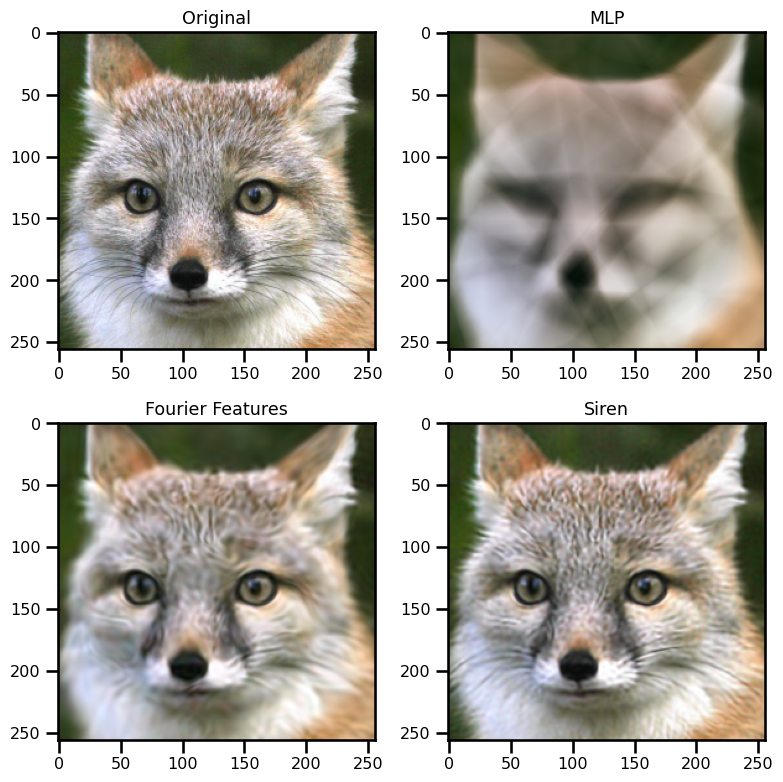

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

ax[0,0].imshow(img)
ax[0,0].set(title="Original")
ax[0,1].imshow(out_mlp)
ax[0,1].set(title="MLP")
ax[1,0].imshow(out_rff)
ax[1,0].set(title="Fourier Features")
ax[1,1].imshow(out_siren)
ax[1,1].set(title="Siren")

plt.tight_layout()
plt.show()

## Multiplicative Filter Networks (MFN)

### Fourier Network

In [49]:
import optax

num_epochs = 2_000

@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4

@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e0
    warmup_steps: int = 500
    end_value: float = 1e-5

use_scheduler = False

In [50]:
optim_config = OmegaConf.structured(Optimizer())
scheduler_config = OmegaConf.structured(Scheduler())

# initialize optimizer
optimizer = hydra.utils.instantiate(optim_config)

if use_scheduler:
    num_steps_per_epoch = len(dm.ds_train)

    scheduler = hydra.utils.instantiate(
        scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
    )

    # initialize optimizer with scheduler
    optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

In [53]:
from typing import Dict
from dataclasses import field

@dataclass
class IdentityAct:
    _target_: str = "equinox.nn.Identity"
    
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123


@dataclass
class MFNModel:
    _target_: str = "jejeqx._src.nets.nerfs.mfn.FourierNet"
    in_size: int = 2
    out_size: int = 3
    width_size: int = 256
    depth: int = 4
    final_activation: IdentityAct = IdentityAct()
    key: Key = Key(seed=123)

In [54]:
# initialize model
model_config = OmegaConf.structured(MFNModel())

model = hydra.utils.instantiate(model_config)

# eqx.tree_pprint(model)

In [58]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [59]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.38080090284347534, 'psnr': 3.2654476165771484}

In [60]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_mfnfourier.ckpt")
except:
    pass

In [61]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.0027426695451140404, 'psnr': 52.616703033447266}

In [62]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 47.9 µs


In [63]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_mfnfourier.ckpt")

In [64]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.0027426695451140404, 'psnr': 52.616703033447266}

In [65]:
all_metrics = pd.concat(
    [all_metrics,
    pd.DataFrame(
        data=[["mfnfourier", metrics["loss"], metrics["psnr"]]],
        columns=["model", "MSE", "SNR"],
    )]
)


In [66]:
out_mfn_fourier = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


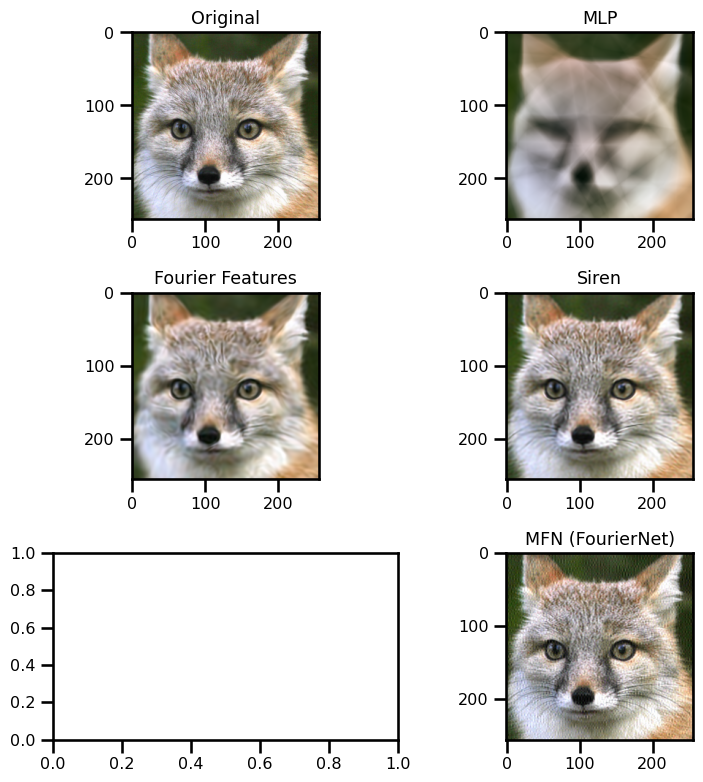

In [67]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8,8))

ax[0,0].imshow(img)
ax[0,0].set(title="Original")
ax[0,1].imshow(out_mlp)
ax[0,1].set(title="MLP")
ax[1,0].imshow(out_rff)
ax[1,0].set(title="Fourier Features")
ax[1,1].imshow(out_siren)
ax[1,1].set(title="Siren")
ax[2,1].imshow(out_mfn_fourier)
ax[2,1].set(title="MFN (FourierNet)")

plt.tight_layout()
plt.show()

### GaborNet

In [121]:
from typing import Dict
from dataclasses import field

@dataclass
class IdentityAct:
    _target_: str = "equinox.nn.Identity"
    
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123


@dataclass
class MFNModel:
    _target_: str = "jejeqx._src.nets.nerfs.mfn.GaborNet"
    in_size: int = 2
    out_size: int = 3
    width_size: int = 256
    depth: int = 4
    final_activation: IdentityAct = IdentityAct()
    key: Key = Key(seed=123)

In [137]:
x_ = jrandom.normal(key=jrandom.PRNGKey(123), shape=(10,))
y_ = jrandom.normal(key=jrandom.PRNGKey(42), shape=(10,20))

In [159]:
from scipy.spatial.distance import pdist, cdist
import einops

In [161]:
cdist(einops.repeat(x_, "D -> D R", R=20), y_, metric="sqeuclidean").shape

(10, 10)

In [145]:
def norm(x,y):
    
    a = np.sum(x**2, axis=-1)[..., None]
    b = np.sum(y**2, axis=0)[None, :]
    c = - 2 * a @ b
    
    D = a + b + c
    return D.squeeze()

def norm2(x,y):
    
    a = np.sum(x**2, axis=-1)[..., None]
    b = np.sum(y**2, axis=0)[None, :]
    c = np.einsum("i,ij->j", x, y)
    
    D = a + b - 2 * c
    return D.squeeze()

def norm3(x,y):
    
    a_min_b = x[..., None] - y
    
    D = np.einsum("ij,ij->j", a_min_b, a_min_b)   
    
    return np.sqrt(D).squeeze()


def norm4(x, y):
    
    return np.linalg.norm(x[..., None] - y, ord=2, axis=1)

In [150]:
norm(x_, y_), norm2(x_, y_), norm3(x_, y_), norm4(x_, y_)

(Array([-217.20114 ,  -77.375015,  -74.17507 , -156.64224 , -125.53166 ,
        -315.88028 , -212.1012  ,  -81.85537 , -104.37545 , -154.33092 ,
        -147.86035 ,  -30.779745, -100.869064,  -99.64139 , -265.01154 ,
        -191.5873  , -153.27542 , -218.29437 , -104.01573 ,  -33.691277],      dtype=float32),
 Array([14.338984 ,  9.937674 , 11.39203  , 10.020089 , 18.47353  ,
        20.160423 , 31.638237 , 13.113626 , 22.87643  , 16.595543 ,
        16.976677 , 17.122837 , 13.527521 , 19.920753 , 15.957615 ,
        17.846594 , 15.2241535, 22.751919 , 21.868273 , 13.657897 ],      dtype=float32),
 array([3.786685 , 3.1524074, 3.3752081, 3.1654522, 4.2980843, 4.490036 ,
        5.624788 , 3.621274 , 4.7829313, 4.0737624, 4.120276 , 4.1379747,
        3.6779776, 4.4632673, 3.9946985, 4.2245226, 3.9018142, 4.769897 ,
        4.6763525, 3.6956594], dtype=float32),
 array([2.926376 , 5.3133593, 5.0965524, 8.420098 , 4.9557424, 4.2227163,
        6.0888925, 5.4001536, 4.7845078, 8.843863

In [106]:
o_ = norm(x_, y_)
o__ = norm2(x_, y_)
o_.shape, o__.shape

((20,), (20,))

In [107]:
o_

Array([-217.20114 ,  -77.375015,  -74.17507 , -156.64224 , -125.53166 ,
       -315.88028 , -212.1012  ,  -81.85537 , -104.37545 , -154.33092 ,
       -147.86035 ,  -30.779745, -100.869064,  -99.64139 , -265.01154 ,
       -191.5873  , -153.27542 , -218.29437 , -104.01573 ,  -33.691277],      dtype=float32)

In [108]:
o__

Array([14.338984 ,  9.937674 , 11.39203  , 10.020089 , 18.47353  ,
       20.160423 , 31.638237 , 13.113626 , 22.87643  , 16.595543 ,
       16.976677 , 17.122837 , 13.527521 , 19.920753 , 15.957615 ,
       17.846594 , 15.2241535, 22.751919 , 21.868273 , 13.657897 ],      dtype=float32)

In [219]:
a = (x_**2).sum(axis=-1)[..., None]
b = (y_**2).sum(axis=0)[None, ...]
c = jnp.einsum("i,ij -> j", x_, y_)
a.shape, b.shape, (a + b).shape, c.shape

((1,), (1, 20), (1, 20), (20,))

In [207]:
x_.shape, y_.shape

((10,), (10, 20))

In [75]:
from jejeqx._src.nets.nerfs.mfn import GaborLayer

layer = GaborLayer(2, 3)
layer(x_init[0])

Array([-7.9427886e-01,  5.3681031e-02,  2.6021642e-06], dtype=float32)

In [76]:
# initialize model
model_config = OmegaConf.structured(MFNModel())

model = hydra.utils.instantiate(model_config)

# eqx.tree_pprint(model)

In [125]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True

In [126]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.3797137439250946, 'psnr': 3.29753041267395}

In [127]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_mfngabor.ckpt")
except:
    pass

In [128]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.007976262830197811, 'psnr': 42.6780891418457}

In [129]:
%%time
# 
if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 2000 | Loss: 9.722e-04: 100%|██████████| 2000/2000 [08:13<00:00,  4.06it/s]

CPU times: user 8min 16s, sys: 8.26 s, total: 8min 24s
Wall time: 8min 13s


In [130]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_mfngabor.ckpt")

In [131]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 0.0028547486290335655, 'psnr': 52.77768325805664}

In [132]:
all_metrics = pd.concat(
    [all_metrics,
    pd.DataFrame(
        data=[["mfngabor", metrics["loss"], metrics["psnr"]]],
        columns=["model", "MSE", "SNR"],
    )]
)


In [133]:
out_mfn_gabor = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


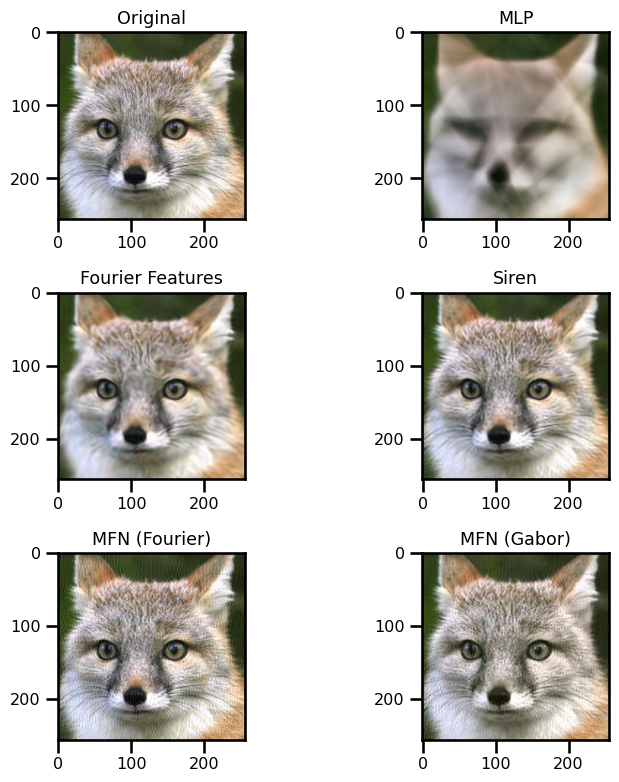

In [134]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8,8))

ax[0,0].imshow(img)
ax[0,0].set(title="Original")
ax[0,1].imshow(out_mlp)
ax[0,1].set(title="MLP")
ax[1,0].imshow(out_rff)
ax[1,0].set(title="Fourier Features")
ax[1,1].imshow(out_siren)
ax[1,1].set(title="Siren")
ax[2,0].imshow(out_mfn_fourier)
ax[2,0].set(title="MFN (Fourier)")
ax[2,1].imshow(out_mfn_gabor)
ax[2,1].set(title="MFN (Gabor)")

plt.tight_layout()
plt.show()

In [135]:
all_metrics

,model,MSE,SNR
0,mlp,0.008850,41.515614
0,rff,0.002839,53.401886
0,siren,0.001935,57.650528
0,mfnfourier,0.002743,52.616703
0,mfngabor,0.007976,42.678089
0,mfngabor,0.002855,52.777683
